In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [3]:

train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")


train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

df = train.merge(features, on=["Store", "Date", "IsHoliday"], how="left")
df = df.merge(stores, on="Store", how="left")

df = df.sort_values("Date").reset_index(drop=True)

df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,29,5,2010-02-05,15552.08,False,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,B,93638
2,29,6,2010-02-05,3200.22,False,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,B,93638
3,29,7,2010-02-05,10820.05,False,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,B,93638
4,29,8,2010-02-05,20055.64,False,24.36,2.788,NaN,NaN,NaN,NaN,NaN,131.527903,10.064,B,93638


In [4]:

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['Day'] = df['Date'].dt.day

df['Sales_Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)
df['Sales_Lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)

df['Rolling_Mean_4'] = df.groupby('Store')['Weekly_Sales'].transform(lambda x: x.shift(1).rolling(4).mean())


df = df.dropna()


In [5]:

features = ['Store', 'Type', 'Size', 'Temperature', 'Fuel_Price',
            'CPI', 'Unemployment', 'IsHoliday', 'Year', 'Month', 'Week', 'Day',
            'Sales_Lag_1', 'Sales_Lag_2', 'Rolling_Mean_4']


df['Type'] = df['Type'].astype('category').cat.codes
df['IsHoliday'] = df['IsHoliday'].astype(int)

X = df[features]
y = df['Weekly_Sales']


In [6]:

train_data = df[df['Date'] < '2012-01-01']
test_data = df[df['Date'] >= '2012-01-01']

X_train = train_data[features]
y_train = train_data['Weekly_Sales']
X_test = test_data[features]
y_test = test_data['Weekly_Sales']


In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


rf_pred = rf_model.predict(X_test)


mse = mean_squared_error(y_test, rf_pred)
rmse = np.sqrt(mse)
print("📊 Random Forest Results")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2_score(y_test, rf_pred):.2f}")


📊 Random Forest Results
RMSE: 24165.06
R²: -0.07


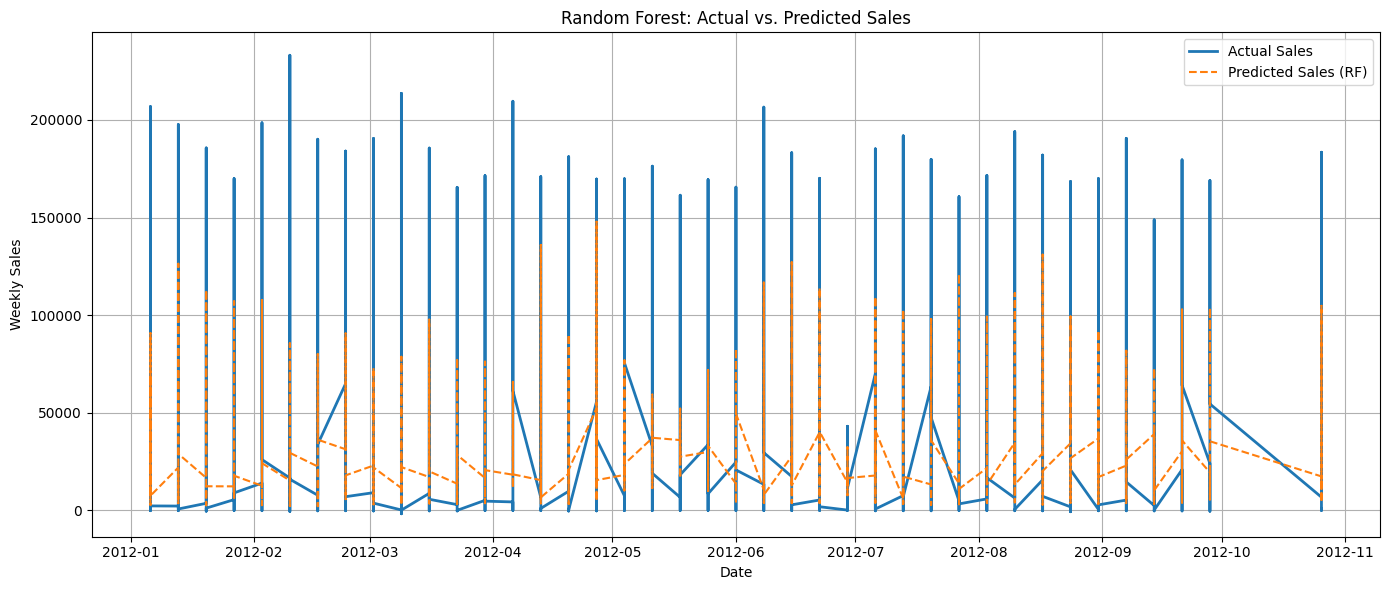

In [10]:
import matplotlib.pyplot as plt

#Actual vs Prediction 
plt.figure(figsize=(14,6))
plt.plot(test_data['Date'], y_test.values, label='Actual Sales', linewidth=2)
plt.plot(test_data['Date'], rf_pred, label='Predicted Sales (RF)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Random Forest: Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)


xgb_pred = xgb_model.predict(X_test)


from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("📊 XGBoost Results")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2_score(y_test, xgb_pred):.2f}")


📊 XGBoost Results
RMSE: 27122.36
R²: -0.35


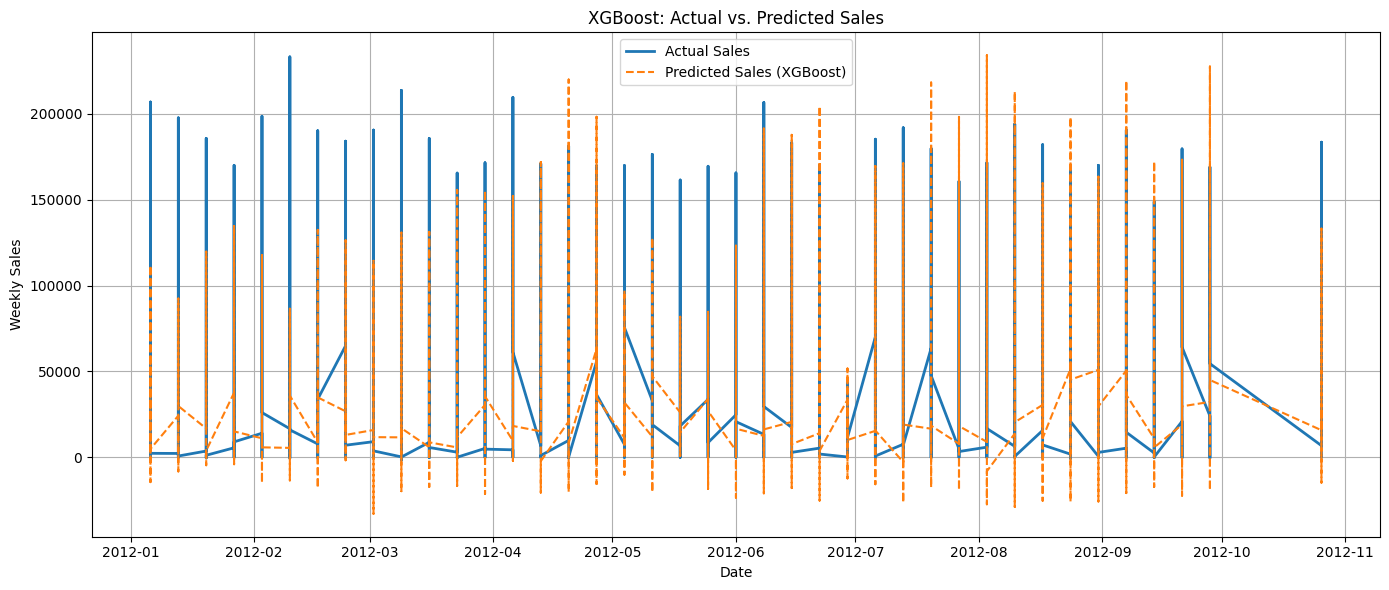

In [14]:
plt.figure(figsize=(14,6))
plt.plot(test_data['Date'], y_test.values, label='Actual Sales', linewidth=2)
plt.plot(test_data['Date'], xgb_pred, label='Predicted Sales (XGBoost)', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('XGBoost: Actual vs. Predicted Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


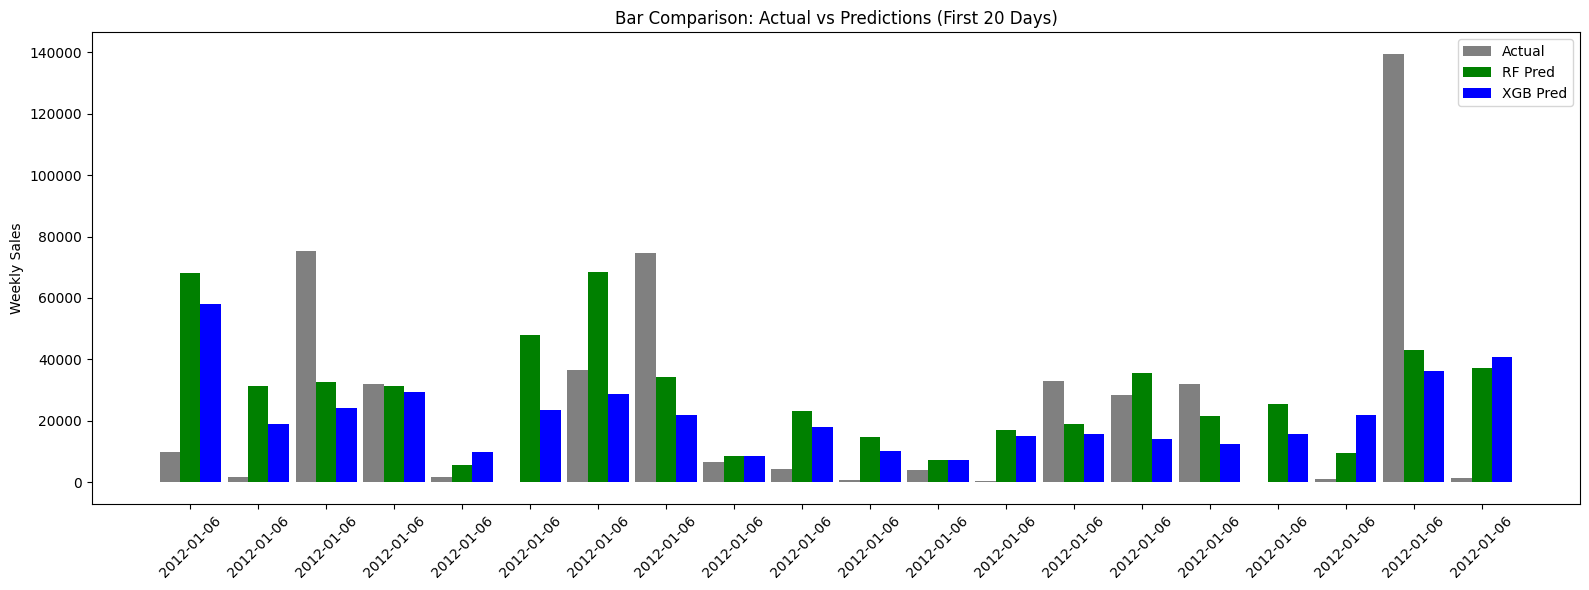

In [16]:
sample = test_data.head(20).copy()
sample['RF_Pred'] = rf_pred[:20]
sample['XGB_Pred'] = xgb_pred[:20]

x = np.arange(len(sample))
width = 0.3

plt.figure(figsize=(16,6))
plt.bar(x - width, sample['Weekly_Sales'], width=width, label='Actual', color='gray')
plt.bar(x, sample['RF_Pred'], width=width, label='RF Pred', color='green')
plt.bar(x + width, sample['XGB_Pred'], width=width, label='XGB Pred', color='blue')

plt.xticks(x, sample['Date'].dt.strftime('%Y-%m-%d'), rotation=45)
plt.ylabel('Weekly Sales')
plt.title('Bar Comparison: Actual vs Predictions (First 20 Days)')
plt.legend()
plt.tight_layout()
plt.show()
